In [1]:
# Manipulación de datos
# ==============================================================================
import sys
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns 
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

# Modelado y Forecasting
# ==============================================================================
import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from lightgbm import LGBMRegressor
import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
import plotly.graph_objects as go

# Warnings
# ==============================================================================
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión scikit-learn: 1.5.2
Versión pandas: 2.2.2
Versión numpy: 1.26.4


c:\Users\HP\miniconda3\envs\Forecasting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Datafest2024_Train.csv')
dfTest = pd.read_csv('Datafest2024_Test.csv')
df

,fecha_transaccion,codigo_cajero,tipo_cajero,saldo_inicial,demanda,abastecimiento,saldo_final
0,20230602,6,B,644690,243020,0,401670
1,20230603,6,B,401670,364110,0,37560
2,20230604,6,B,37560,-5850,0,43410
3,20230605,6,B,43410,25550,438700,456560
4,20230606,6,B,456560,45820,0,410740
...,...,...,...,...,...,...,...
222595,20240410,698,A,754240,341960,0,412280
222596,20240411,698,A,412280,343170,0,69110
222597,20240412,698,A,69110,13080,236970,293000
222598,20240413,698,A,293000,41710,0,251290


In [3]:
def changeDate(date):
    year = date[:4]
    month = date[4:6]
    day  = date[6:]
    return year + "/" + month + "/" + day

def suavizado_de_neg(x):
    if x < 0:
        return 0
    else:
        return x


df["fecha_transaccion"] = df["fecha_transaccion"].astype('string')
df["fecha_transaccion"] = df["fecha_transaccion"].apply(lambda x :changeDate(x))
df["fecha_transaccion"] = pd.to_datetime(df['fecha_transaccion'], format='%Y/%m/%d')
df["demanda"] = df["demanda"].apply(lambda x :suavizado_de_neg(x))

dfTest["fecha_transaccion"] = dfTest["fecha_transaccion"].astype('string')
dfTest["fecha_transaccion"] = dfTest["fecha_transaccion"].apply(lambda x :changeDate(x))
dfTest["fecha_transaccion"] = pd.to_datetime(dfTest['fecha_transaccion'], format='%Y/%m/%d')
dfTest["demanda"] = dfTest["demanda"].apply(lambda x :suavizado_de_neg(x))

## MODELO PARA LOS CAJEROS TIPO A

In [4]:
#Cajero A
dfA = df[df["tipo_cajero"]=="A"].copy()
selected_ATMs = dfA.codigo_cajero.unique()
selected_ATMs = selected_ATMs
dfModelA = dfA[dfA.codigo_cajero.isin(selected_ATMs)]
dfModelA = pd.pivot_table(
           data    = dfModelA,
           values  = 'demanda',
           index   = 'fecha_transaccion',
           columns = 'codigo_cajero'
       )
dfModelA.columns.name = None
dfModelA.columns = [f"Cajero_{col}" for col in dfModelA.columns]
dfModelA = dfModelA.asfreq('1D')
dfModelA = dfModelA.sort_index()



test_dfA = dfTest[dfTest["tipo_cajero"]=="A"].copy()
test_dfA =  test_dfA[test_dfA.codigo_cajero.isin(selected_ATMs)]
test_dfA = pd.pivot_table(
           data    = test_dfA,
           values  = 'demanda',
           index   = 'fecha_transaccion',
           columns = 'codigo_cajero'
       )
test_dfA.columns.name = None
test_dfA.columns = [f"{col}" for col in dfModelA.columns]
test_dfA = test_dfA.asfreq('1D')
test_dfA = test_dfA.sort_index()


### GRÁFICAS


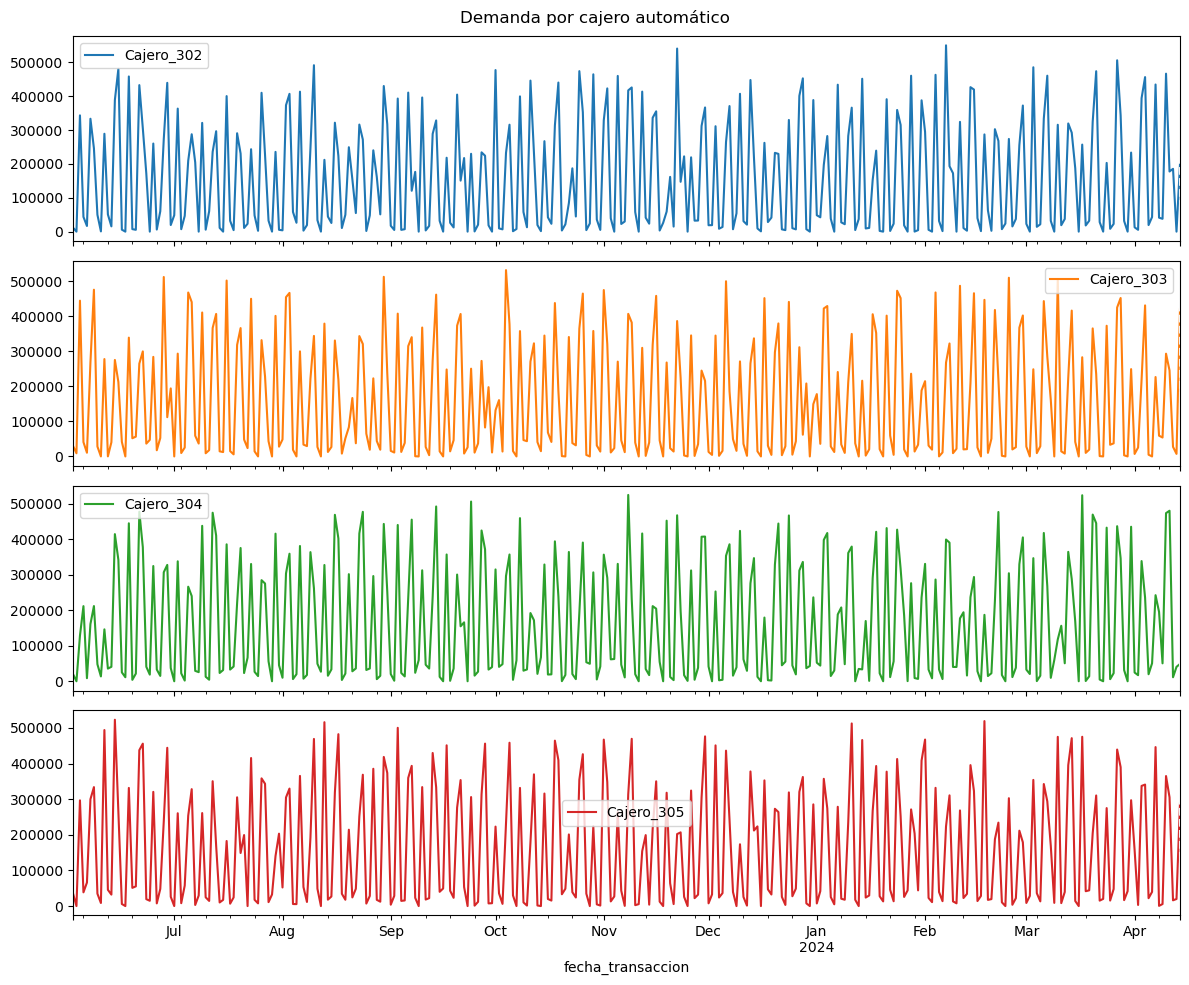

In [5]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
dfModelA.iloc[:, :4].plot(
    legend   = True,
    subplots = True, 
    title    = 'Demanda por cajero automático',
    ax       = axs, 
)
for ax in axs:
    ax.axvline(pd.to_datetime(dfModelA.index.max()) , color='white', linestyle='--', linewidth=1.5)
fig.tight_layout();

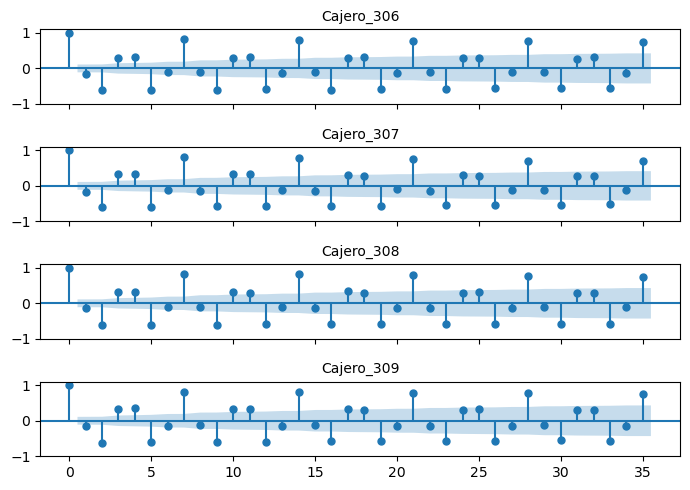

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 5), sharex=True)
axes = axes.flat
for i, col in enumerate(dfModelA.columns[4:8]):
    plot_acf(dfModelA[col], ax=axes[i], lags=7*5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}', fontsize=10)
fig.tight_layout()
plt.show()

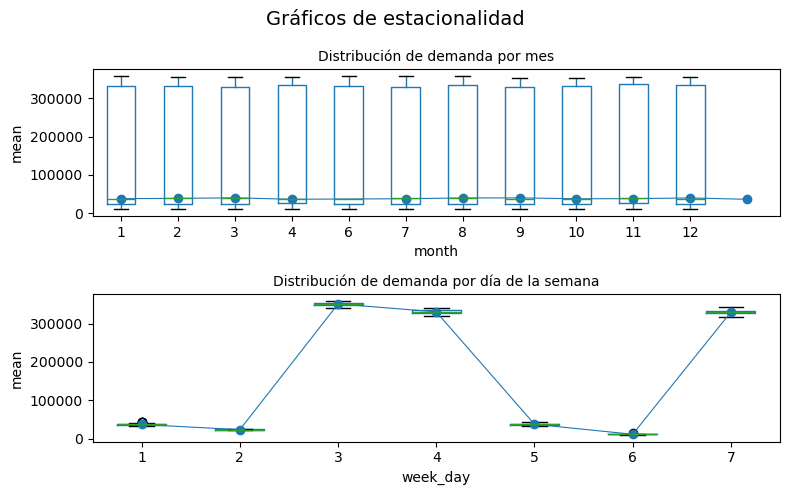

In [7]:
# Estacionalidad anual, semanal y diaria
# ==============================================================================
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()
datos = dfModelA.copy()
datos["mean"] = datos.iloc[:,:-1].mean(axis=1)
# Distribusión de usuarios por mes
datos['month'] = datos.index.month
datos.boxplot(column="mean", by='month', ax=axs[0])
datos.groupby('month')["mean"].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel("mean")
axs[0].set_title('Distribución de demanda por mes', fontsize=10)

# Distribusión de usuarios por día de la semana
datos['week_day'] = datos.index.day_of_week + 1
datos.boxplot(column="mean", by='week_day', ax=axs[1])
datos.groupby('week_day')["mean"].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel("mean")
axs[1].set_title('Distribución de demanda por día de la semana', fontsize=10)



fig.suptitle("Gráficos de estacionalidad", fontsize=14)
fig.tight_layout()

### VARIABLES EXOGENAS

In [8]:
def codificacion_ciclica(datos: pd.Series, longitud_ciclo: int) -> pd.DataFrame:
    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({
                  f"{datos.name}_seno": seno,
                  f"{datos.name}_coseno": coseno
              })

    return resultado

def is_maximum_day(x,days):
    if x in days:
        return 1
    else:
        return 0
calendar =  pd.DataFrame(index=dfModelA.index)
calendar["month"] = calendar.index.month
calendar["week_year"] = calendar.index.isocalendar().week
calendar["day_of_week"] = calendar.index.dayofweek + 1
calendar["maximum_day"] = calendar["day_of_week"].apply(lambda x:is_maximum_day(x,[3,4,7]) )
#Concatenar las variables exógenas
exogenous_features = calendar

# Codificación de variables cíclicas
month_coded = codificacion_ciclica(exogenous_features["month"], 12)
week_year_coded = codificacion_ciclica(exogenous_features["week_year"], 52)
day_of_week_coded = codificacion_ciclica(exogenous_features["day_of_week"], 7)

cyclic_features = pd.concat([month_coded, week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = pd.concat([week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = day_of_week_coded
exogenous_features = pd.concat([exogenous_features, cyclic_features], axis=1)
exogenous_features = exogenous_features.drop(columns=["month", "week_year", "day_of_week"])
exogenous_features.head(5)

,maximum_day,month_seno,month_coseno,week_year_seno,week_year_coseno,day_of_week_seno,day_of_week_coseno
fecha_transaccion,,,,,,,
2023-06-02,0,1.224647e-16,-1.0,0.464723,-0.885456,-9.749279e-01,-0.222521
2023-06-03,0,1.224647e-16,-1.0,0.464723,-0.885456,-7.818315e-01,0.623490
2023-06-04,1,1.224647e-16,-1.0,0.464723,-0.885456,-2.449294e-16,1.000000
2023-06-05,0,1.224647e-16,-1.0,0.354605,-0.935016,7.818315e-01,0.623490
2023-06-06,0,1.224647e-16,-1.0,0.354605,-0.935016,9.749279e-01,-0.222521


In [9]:
calendar =  pd.DataFrame(index=test_dfA.index)
calendar["month"] = calendar.index.month
calendar["week_year"] = calendar.index.isocalendar().week
calendar["day_of_week"] = calendar.index.dayofweek + 1
calendar["maximum_day"] = calendar["day_of_week"].apply(lambda x:is_maximum_day(x,[3,4,7]) )

#Concatenar las variables exógenas
exogenous_features_test = calendar

# Codificación de variables cíclicas
month_coded = codificacion_ciclica(exogenous_features_test["month"], 12)
week_year_coded = codificacion_ciclica(exogenous_features_test["week_year"], 52)
day_of_week_coded = codificacion_ciclica(exogenous_features_test["day_of_week"], 7)

cyclic_features = pd.concat([month_coded, week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = day_of_week_coded
exogenous_features_test = pd.concat([exogenous_features_test, cyclic_features], axis=1)
exogenous_features_test = exogenous_features_test.drop(columns=["month", "week_year", "day_of_week"])

lastDate = exogenous_features_test.tail(1).index.tolist()[0]
lastDate = str(lastDate)[:10]
lastDate = datetime.datetime.strptime(lastDate,"%Y-%m-%d")
dates = []
for i in range(7):
    dates.append(lastDate+datetime.timedelta(days=i+1))
dates = [str(date)[:10] for date in dates ]
calendar =  pd.DataFrame(index=pd.to_datetime(dates, format='%Y-%m-%d'))

calendar["month"] = calendar.index.month
calendar["week_year"] = calendar.index.isocalendar().week
calendar["day_of_week"] = calendar.index.dayofweek + 1
calendar["maximum_day"] = calendar["day_of_week"].apply(lambda x:is_maximum_day(x,[3,4,7]) )

#Concatenar las variables exógenas
exogenous_features_predict = calendar

# Codificación de variables cíclicas
month_coded = codificacion_ciclica(exogenous_features_predict["month"], 12)
week_year_coded = codificacion_ciclica(exogenous_features_predict["week_year"], 52)
day_of_week_coded = codificacion_ciclica(exogenous_features_predict["day_of_week"], 7)

cyclic_features = pd.concat([month_coded, week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = pd.concat([week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = day_of_week_coded
exogenous_features_predict = pd.concat([exogenous_features_predict, cyclic_features], axis=1)
exogenous_features_predict = exogenous_features_predict.drop(columns=["month", "week_year", "day_of_week"])
exogenous_features_predict = exogenous_features_predict.asfreq('1D')
exogenous_features_predict = exogenous_features_predict.sort_index()

exogenous_features_test = pd.concat([exogenous_features_test,exogenous_features_predict],axis=0)
exogenous_features_test.head(5)

,maximum_day,month_seno,month_coseno,week_year_seno,week_year_coseno,day_of_week_seno,day_of_week_coseno
2024-04-15,0,0.866025,-0.5,0.935016,-0.354605,0.781831,0.623490
2024-04-16,0,0.866025,-0.5,0.935016,-0.354605,0.974928,-0.222521
2024-04-17,1,0.866025,-0.5,0.935016,-0.354605,0.433884,-0.900969
2024-04-18,1,0.866025,-0.5,0.935016,-0.354605,-0.433884,-0.900969
2024-04-19,0,0.866025,-0.5,0.935016,-0.354605,-0.974928,-0.222521


In [10]:
dfModelA = pd.concat([dfModelA, exogenous_features], axis=1)
dfModelA = dfModelA.astype({col: np.float32 for col in dfModelA.select_dtypes("number").columns})
test_dfA = pd.concat([test_dfA,exogenous_features_test], axis=1)
test_dfA = test_dfA.astype({col: np.float32 for col in test_dfA.select_dtypes("number").columns})
test_dfA.fillna(0,inplace=True)
exog_col = exogenous_features.columns.to_list()

In [11]:
dates = dfModelA.index.unique().to_list()
train_percentage = 0.85
validation_percentage = 0.15
train_cutoff = int(len(dates) * train_percentage)

train_dates = dates[:train_cutoff]
validation_dates = dates[train_cutoff:]

train_dfA = dfModelA.loc[train_dates]
train_dfA = train_dfA.asfreq("D")
validation_dfA = dfModelA.loc[validation_dates]
validation_dfA = validation_dfA.asfreq("D")
test_dfA = test_dfA.asfreq("D")

print(
    f"Fechas train      : {train_dfA.index.min()} --- {train_dfA.index.max()}  "
    f"(n={len(train_dfA)})"
)
print(
    f"Fechas validación : {validation_dfA.index.min()} --- {validation_dfA.index.max()}  "
    f"(n={len(validation_dfA)})"
)
print(
    f"Fechas test : {test_dfA.index.min()} --- {test_dfA.index.max()}  "
    f"(n={len(test_dfA)})"
)

Fechas train      : 2023-06-02 00:00:00 --- 2024-02-26 00:00:00  (n=270)
Fechas validación : 2024-02-27 00:00:00 --- 2024-04-14 00:00:00  (n=48)
Fechas test : 2024-04-15 00:00:00 --- 2024-05-27 00:00:00  (n=43)


### MODELO DE FORECASTING UNITARIO

In [12]:
items = []
mae_values = []
predictions = {}

lags_grid = [1,2,7,[1,2,3,7,14,24,28]]

def search_space(trial):
    search_space  = {
        'max_iter'          : trial.suggest_int('max_iter', 100, 3000, step=100),
        'max_depth'         : trial.suggest_int('max_depth', 3, 100, step=1),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.001, 0.2),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20, step=1),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0, 1),
        'lags'              : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

for i, item in enumerate(tqdm(dfModelA.columns)):
    # Definir el forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123),
                     lags          = 14,
                     transformer_y = StandardScaler()
                 )
    results_bayesian = bayesian_search_forecaster(
                            forecaster         = forecaster,
                            y                  = dfModelA[item],
                            search_space       = search_space,
                            n_trials           = 20,
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(train_dfA),
                            refit              = False,
                            fixed_train_size   = False,
                            return_best        = True,
                            verbose            = False,
                            show_progress      = False 
                        )

    # Backtesting forecaster
    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = pd.concat([dfModelA, test_dfA])[item],
                        initial_train_size = len(dfModelA),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )
    items.append(item)
    mae_values.append(metric.at[0, 'mean_absolute_error'])
    predictions[item] = preds

# Resultados
uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

### MODELO DE FORECASTING GLOBAL

In [13]:
# LGBMRegressor
items = list(dfModelA.drop(columns=exog_col).columns)
mae_values = []
predictions = {}

lags_grid = [[1,2,3,7,14,21,28],[1,2,3,7],7,[1,2,3]]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.001, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Definir el forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = LGBMRegressor(random_state=15926, verbose=-1),
                    lags               = 28,
                )
#hiper param
results_bayesian_ms = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster_ms,
                        series             = dfModelA.drop(columns=exog_col),
                        exog               = dfModelA[exog_col],
                        levels             = None, # Si es None se seleccionan todos los niveles
                        search_space       = search_space,
                        n_trials           = 20,
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(train_dfA),
                        refit              = False,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = True 
                    )      
# Backtesting forecaster para todos los items
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster            = forecaster_ms,
                                       series                = pd.concat([dfModelA, test_dfA]).drop(columns=exog_col),
                                       exog                   = pd.concat([dfModelA, test_dfA])[exog_col],
                                       levels                = items,
                                       steps                 = 7,
                                       metric                = 'mean_absolute_error',
                                       add_aggregated_metric = False,
                                       initial_train_size    = len(dfModelA),
                                       refit                 = False,
                                       fixed_train_size      = False,
                                       verbose               = False,
                                       show_progress         = True  
                                   )   
# Resultados
display(multi_series_mae.head(10))
print('')
display(predictions_ms.head(10))

Best trial: 11. Best value: 48360.7: 100%|██████████| 20/20 [09:55<00:00, 29.77s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  7 14 21 28] 
  Parameters: {'n_estimators': 1200, 'max_depth': 10, 'min_data_in_leaf': 20, 'learning_rate': 0.006079183895567925, 'feature_fraction': 0.5, 'max_bin': 250, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 1.0}
  Backtesting metric: 48360.65403868454
  Levels: ['Cajero_302', 'Cajero_303', 'Cajero_304', 'Cajero_305', 'Cajero_306', 'Cajero_307', 'Cajero_308', 'Cajero_309', 'Cajero_310', 'Cajero_311', 'Cajero_312', 'Cajero_313', 'Cajero_314', 'Cajero_315', 'Cajero_316', 'Cajero_317', 'Cajero_318', 'Cajero_319', 'Cajero_320', 'Cajero_321', 'Cajero_322', 'Cajero_323', 'Cajero_324', 'Cajero_325', 'Cajero_326', 'Cajero_327', 'Cajero_328', 'Cajero_329', 'Cajero_330', 'Cajero_331', 'Cajero_332', 'Cajero_333', 'Cajero_334', 'Cajero_335', 'Cajero_336', 'Cajero_337', 'Cajero_338', 'Cajero_339', 'Cajero_340', 'Cajero_341', 'Cajero_342', 'Cajero_343', 'Cajero_344', 'Cajero_345', 'C

100%|██████████| 7/7 [00:22<00:00,  3.25s/it]


,levels,mean_absolute_error
0,Cajero_302,66735.454213
1,Cajero_303,74017.960364
2,Cajero_304,76930.972674
3,Cajero_305,70949.254964
4,Cajero_306,61792.751418
5,Cajero_307,74652.547631
6,Cajero_308,66756.934276
7,Cajero_309,67837.859889
8,Cajero_310,66739.467502
9,Cajero_311,66388.898412


,Cajero_302,Cajero_303,Cajero_304,Cajero_305,Cajero_306,Cajero_307,Cajero_308,Cajero_309,Cajero_310,Cajero_311,...,Cajero_691,Cajero_692,Cajero_693,Cajero_694,Cajero_695,Cajero_696,Cajero_697,Cajero_698,Cajero_699,Cajero_700
2024-04-15,32219.250700,23837.600817,169073.360976,37693.741748,26455.604317,31093.420475,45725.883562,23326.894093,29848.413148,23208.367211,...,143973.194039,33763.659143,30858.750657,22597.079765,22489.470697,32324.546609,25912.248730,56397.119569,25494.993004,40128.671894
2024-04-16,22875.468236,23042.004895,38073.372033,23193.506574,25305.702032,22851.963144,24184.407698,23083.645855,23105.476309,22844.405451,...,45391.772478,23275.083553,24422.595247,23415.826719,22569.923419,23665.906985,23111.239244,27470.913218,23392.863037,23392.863037
2024-04-17,342365.422114,353177.055058,364363.740843,334185.728232,351826.217809,342010.863229,357763.250608,349033.025910,351205.575806,362843.278677,...,363925.294795,357183.373810,345134.896430,350372.997782,351515.427670,338903.228699,362151.471014,350539.110229,353134.088410,350719.656133
2024-04-18,316020.154976,330509.536449,336809.090433,334717.866679,335145.815987,310764.375497,333038.379962,327578.660308,334071.780329,356732.834163,...,337585.636672,307250.271567,329077.021901,300239.554684,320568.508655,317804.310233,343641.063517,328870.967691,337283.049396,326828.715684
2024-04-19,30701.161919,25101.915608,27255.885699,25718.950693,26859.802271,30117.804300,26096.946486,24304.887340,24746.767602,24442.962213,...,25741.877001,30587.039548,29800.306859,43710.728713,26886.292356,30961.265735,24598.913849,25179.600177,28151.593644,25849.844774
2024-04-20,12396.455569,12123.748392,13977.103836,13594.937335,13869.811698,13134.644361,12751.198901,13089.149396,12495.725051,12721.003407,...,12987.714084,12825.821477,13101.851693,12723.836279,12065.994840,13081.075246,12425.775111,13790.469422,12458.661702,12587.467921
2024-04-21,319303.534102,324647.635029,334698.538803,323516.663870,332149.068527,320352.196349,324761.114249,330612.352325,328274.797521,346228.846151,...,301035.870420,311415.980899,324810.757763,309612.183604,323126.077759,326784.745758,328753.853175,335096.829105,321251.838906,328136.705132
2024-04-22,21155.635332,25484.530263,30380.662348,30242.545761,28347.910406,111511.033355,26121.913169,23711.133844,28425.963458,43357.860648,...,27405.020264,20883.902310,32730.340680,26592.303887,61522.704617,179514.723612,22327.472470,26257.714787,36929.805735,39892.471192
2024-04-23,22841.154702,22490.158904,23983.915903,23193.506574,26130.316047,49137.278657,23404.877998,22531.799864,22553.630318,23396.251442,...,21968.098628,22950.885627,24422.595247,24191.274653,27418.619360,32491.099013,22559.393253,23392.863037,23457.883806,23421.417277
2024-04-24,345797.525259,345011.318486,344598.125406,325835.940955,351935.910811,338734.597314,358581.191249,351778.889087,349037.308780,362037.852675,...,354314.252756,356246.964553,352445.485890,349727.319790,334559.563819,352203.319921,360464.218273,352351.594021,354654.378986,347777.578051


In [14]:
fig = go.Figure()
cajero = "Cajero_316"
test_cajero = test_dfA[cajero].copy()
test_cajero = pd.DataFrame(test_cajero)
pre_cajero = predictions_ms[cajero].copy()
pre_cajero = pd.DataFrame(pre_cajero)
trace1 = go.Scatter(x=test_cajero[:-7].index, y=test_cajero[cajero][:-7], name="test", mode="lines")
trace2 = go.Scatter(x=pre_cajero.index, y=pre_cajero[cajero], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

In [164]:
# HistGradientBoostingRegressor
items = list(dfModelA.drop(columns=exog_col).columns)
mae_values = []
predictions = {}

lags_grid = [[1,2,3,7,14,21,28],[1,2,3,7],7,[1,2,3]]

def search_space(trial):
    search_space  = {
        'max_iter'          : trial.suggest_int('max_iter', 100, 500, step=10),
        'max_depth'         : trial.suggest_int('max_depth', 3, 30, step=1),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.005, 0.5),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 30, step=1),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0, 1),
        'lags'              : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Definir el forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=123),
                    lags               = 28,
                    encoding           = 'ordinal',
                    transformer_series = MinMaxScaler(),
                )
#hiper param
results_bayesian_ms = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster_ms,
                        series             = dfModelA.drop(columns=exog_col),
                        exog               = dfModelA[exog_col],
                        levels             = None, # Si es None se seleccionan todos los niveles
                        search_space       = search_space,
                        n_trials           = 20,
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(train_dfA),
                        refit              = False,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = True 
                    )      
# Backtesting forecaster para todos los items
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster            = forecaster_ms,
                                       series                = pd.concat([dfModelA, test_dfA]).drop(columns=exog_col),
                                       exog                   = pd.concat([dfModelA, test_dfA])[exog_col],
                                       levels                = items,
                                       steps                 = 7,
                                       metric                = 'mean_absolute_error',
                                       add_aggregated_metric = False,
                                       initial_train_size    = len(dfModelA),
                                       refit                 = False,
                                       fixed_train_size      = False,
                                       verbose               = False,
                                       show_progress         = True  
                                   )   
# Resultados
display(multi_series_mae.head(10))
print('')
display(predictions_ms.head(10))

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning:

ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning:

Attribute n is deprecated and will be removed in Python 3.14; use value instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning:

ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning:

Attribute n is deprecated and will be removed in Python 3.14; use value instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning:

ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\ed

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_iter': 310, 'max_depth': 7, 'learning_rate': 0.18027251616132012, 'min_samples_leaf': 1, 'l2_regularization': 0.8334300412171644}
  Backtesting metric: 47985.530937374046
  Levels: ['Cajero_302', 'Cajero_303', 'Cajero_304', 'Cajero_305', 'Cajero_306', 'Cajero_307', 'Cajero_308', 'Cajero_309', 'Cajero_310', 'Cajero_311', 'Cajero_312', 'Cajero_313', 'Cajero_314', 'Cajero_315', 'Cajero_316', 'Cajero_317', 'Cajero_318', 'Cajero_319', 'Cajero_320', 'Cajero_321', 'Cajero_322', 'Cajero_323', 'Cajero_324', 'Cajero_325', 'Cajero_326', 'Cajero_327', 'Cajero_328', 'Cajero_329', 'Cajero_330', 'Cajero_331', 'Cajero_332', 'Cajero_333', 'Cajero_334', 'Cajero_335', 'Cajero_336', 'Cajero_337', 'Cajero_338', 'Cajero_339', 'Cajero_340', 'Cajero_341', 'Cajero_342', 'Cajero_343', 'Cajero_344', 'Cajero_345', 'Cajero_346', 'Cajero_347', 'Cajero_348', 'Cajero_349', 'Cajero_350', 'Cajer

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning:

ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning:

Attribute n is deprecated and will be removed in Python 3.14; use value instead



,levels,mean_absolute_error
0,Cajero_302,71036.364004
1,Cajero_303,75678.629020
2,Cajero_304,74339.916492
3,Cajero_305,71655.290692
4,Cajero_306,61181.906924
5,Cajero_307,72954.978742
6,Cajero_308,65503.608952
7,Cajero_309,67671.265864
8,Cajero_310,66423.130745
9,Cajero_311,66059.004844


,Cajero_302,Cajero_303,Cajero_304,Cajero_305,Cajero_306,Cajero_307,Cajero_308,Cajero_309,Cajero_310,Cajero_311,...,Cajero_691,Cajero_692,Cajero_693,Cajero_694,Cajero_695,Cajero_696,Cajero_697,Cajero_698,Cajero_699,Cajero_700
2024-04-15,38615.296770,23539.039697,180319.965389,38472.897435,23407.739849,26980.032671,50487.191006,23159.728472,24831.215317,24843.202739,...,102417.999026,26008.214710,22640.825365,24322.316844,23512.798213,26868.743643,24193.091313,57631.967264,23693.103026,43824.647937
2024-04-16,24252.297205,23463.923097,27269.873668,23043.957648,23333.042246,23161.176891,22884.430190,23085.822311,23459.076508,24763.924359,...,23525.181650,23630.500598,22509.414282,24203.381679,23397.821562,23013.549472,24052.670622,23016.635059,23555.584349,23870.670047
2024-04-17,364067.046872,352269.600597,340369.572231,339796.700140,349697.549644,346212.736505,340551.939193,346917.183969,353282.715214,372933.113289,...,351080.602342,359204.211135,342162.721719,366875.765083,354665.054697,346565.530834,365621.563568,343742.354552,358065.418834,354574.651665
2024-04-18,336208.104735,327176.275650,329590.794231,325355.748987,331324.080063,330277.782334,323103.393882,327813.611221,332101.598690,350573.854293,...,317107.493696,330993.547257,315290.437835,336083.688959,324897.829924,320947.165027,336906.902891,322718.177516,329944.191788,346848.702224
2024-04-19,26963.607273,26087.096086,25683.872602,25620.180175,25941.583278,25750.504062,25442.818184,25666.725140,26081.707667,27532.432302,...,24929.356362,26272.296287,25025.876993,26909.223187,26013.604663,25586.372487,26741.663235,25589.803030,26189.004700,25094.025852
2024-04-20,13534.658594,13094.684834,12892.282680,12860.311615,13021.643191,12925.729023,12771.282948,12883.675336,13091.980062,13820.186138,...,12513.545532,13187.647970,12561.995051,13507.359945,13057.795062,12843.341499,13423.251513,12845.063496,13145.838906,13321.681108
2024-04-21,340147.081032,333903.545241,325706.948294,324899.240427,328975.075308,326551.927157,322650.045615,325489.494811,331508.580744,349947.851323,...,315853.367300,332868.331156,317076.277593,340938.154666,329590.724657,324177.720021,338815.180687,324221.184784,331813.032022,336251.450504
2024-04-22,24329.937679,24380.464960,25482.659085,27307.343568,23143.664467,27390.971510,22957.691622,26116.179282,27048.180002,37754.358650,...,22553.503480,23745.599547,22640.825365,24344.682229,63582.155506,180110.229625,24193.091313,23128.744004,34477.006710,50620.019068
2024-04-23,24252.297205,23463.923097,23101.245520,23043.957648,23333.042246,24300.077260,22884.430190,23085.822311,23459.076508,24763.924359,...,22422.599227,23630.500598,22509.414282,24203.381679,23397.821562,26872.043236,24052.670622,23016.635059,24713.878845,23870.670047
2024-04-24,363134.151481,351258.686247,342793.834052,341109.047873,333054.069212,347157.688670,341993.858491,345922.559627,352272.009673,372191.563107,...,340843.057197,356962.865751,342162.721719,367912.503024,349306.553152,348320.031240,365621.563568,347689.799314,355046.092794,356496.955603


In [165]:
fig = go.Figure()
cajero = "Cajero_316"
test_cajero = test_dfA[cajero].copy()
test_cajero = pd.DataFrame(test_cajero)
pre_cajero = predictions_ms[cajero].copy()
pre_cajero = pd.DataFrame(pre_cajero)
trace1 = go.Scatter(x=test_cajero[:-7].index, y=test_cajero[cajero][:-7], name="test", mode="lines")
trace2 = go.Scatter(x=pre_cajero.index, y=pre_cajero[cajero], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

In [170]:
predictions_ms.tail(7).T.to_csv("predictionsA2.csv")

#### Comparación y análisis del modelo

In [ ]:
multi_series_mae = multi_series_mae.set_index('levels')
multi_series_mae.columns = ['multi_series_mae']
results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d'])

In [ ]:
results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max'])

,improvement,improvement_(%)
mean,6025.489,9.637
min,-7308.930,-15.840
max,27251.010,35.740


In [ ]:
pd.Series(np.where(results['improvement_(%)'] < 0, 'negative', 'positive')).value_counts()


positive    17
negative     3
Name: count, dtype: int64

## MODELO PARA LOS CAJEROS TIPO B

In [178]:
#Cajero B
dfB = df[df["tipo_cajero"]=="B"].copy()
selected_ATMs = dfB.codigo_cajero.unique()
selected_ATMs = selected_ATMs
dfModelB = dfB[dfB.codigo_cajero.isin(selected_ATMs)]
dfModelB = pd.pivot_table(
           data    = dfModelB,
           values  = 'demanda',
           index   = 'fecha_transaccion',
           columns = 'codigo_cajero'
       )
dfModelB.columns.name = None
dfModelB.columns = [f"Cajero_{col}" for col in dfModelB.columns]
dfModelB = dfModelB.asfreq('1D')
dfModelB = dfModelB.sort_index()



test_dfB = dfTest[dfTest["tipo_cajero"]=="B"].copy()
test_dfB =  test_dfB[test_dfB.codigo_cajero.isin(selected_ATMs)]
test_dfB = pd.pivot_table(
           data    = test_dfB,
           values  = 'demanda',
           index   = 'fecha_transaccion',
           columns = 'codigo_cajero'
       )
test_dfB.columns.name = None
test_dfB.columns = [f"{col}" for col in dfModelB.columns]
test_dfB = test_dfB.asfreq('1D')
test_dfB = test_dfB.sort_index()


### GRÁFICAS


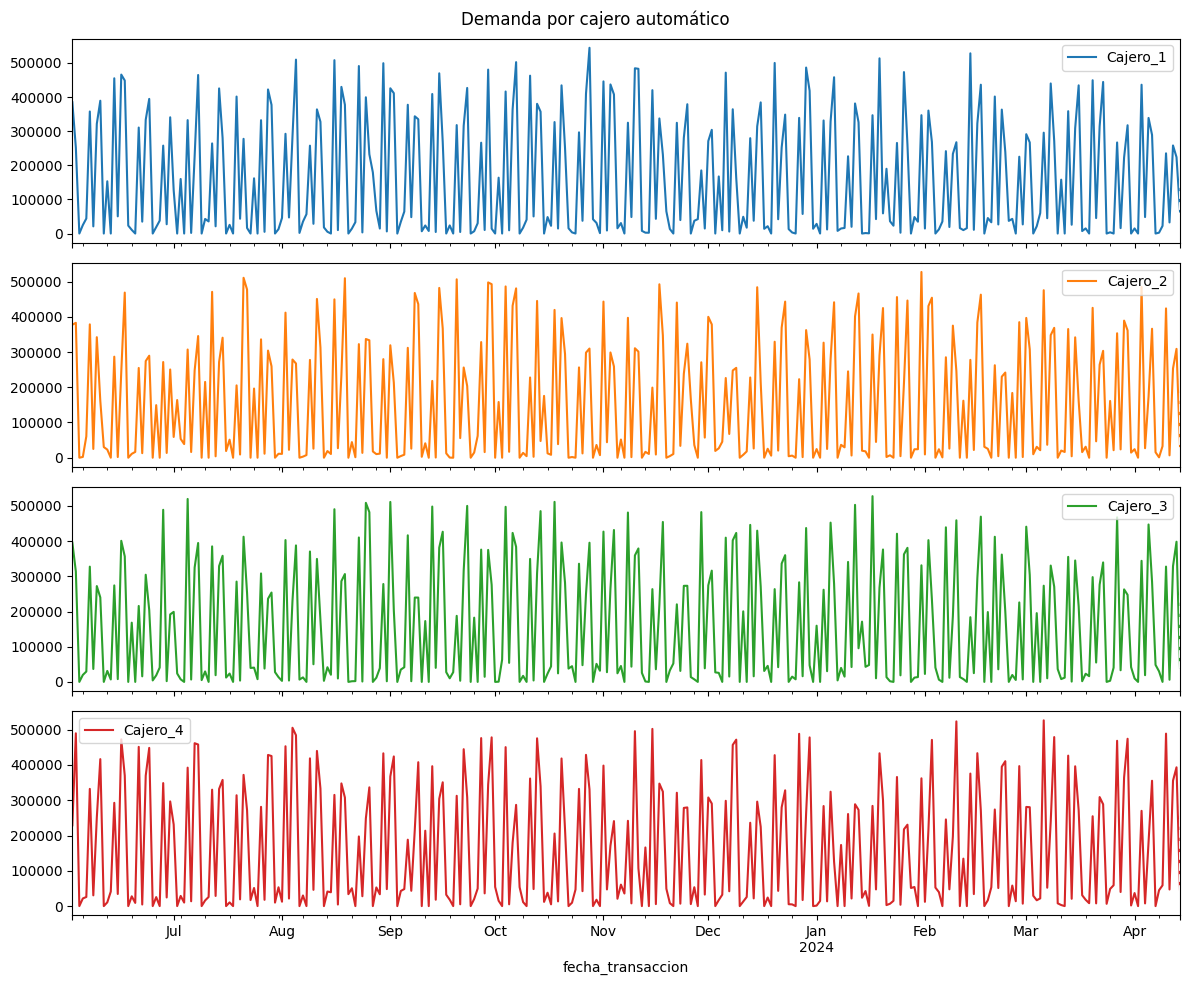

In [179]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
dfModelB.iloc[:, :4].plot(
    legend   = True,
    subplots = True, 
    title    = 'Demanda por cajero automático',
    ax       = axs, 
)
for ax in axs:
    ax.axvline(pd.to_datetime(dfModelB.index.max()) , color='white', linestyle='--', linewidth=1.5)
fig.tight_layout();

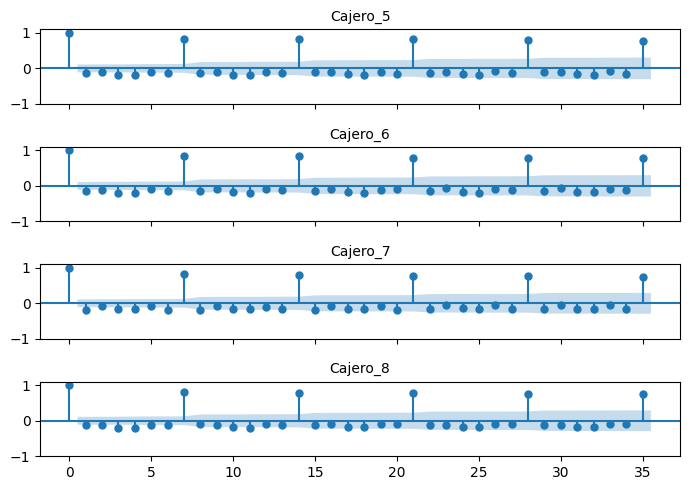

In [180]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 5), sharex=True)
axes = axes.flat
for i, col in enumerate(dfModelB.columns[4:8]):
    plot_acf(dfModelB[col], ax=axes[i], lags=7*5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}', fontsize=10)
fig.tight_layout()
plt.show()

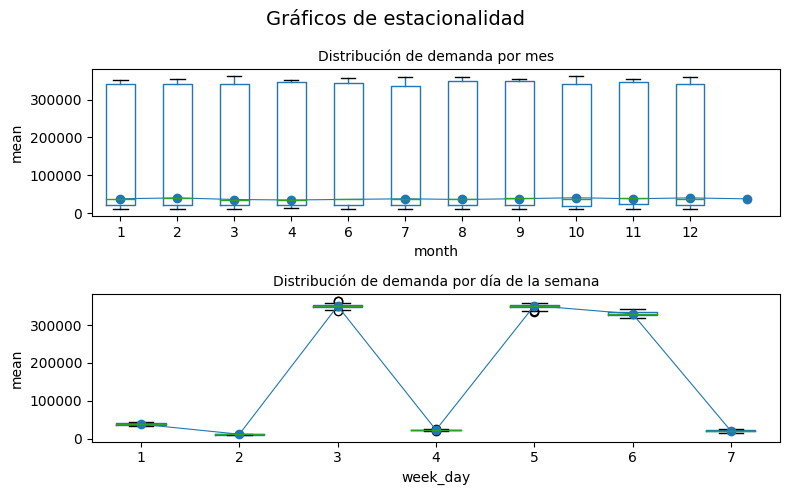

In [181]:
# Estacionalidad anual, semanal y diaria
# ==============================================================================
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()
datos = dfModelB.copy()
datos["mean"] = datos.iloc[:,:-1].mean(axis=1)
# Distribusión de usuarios por mes
datos['month'] = datos.index.month
datos.boxplot(column="mean", by='month', ax=axs[0])
datos.groupby('month')["mean"].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel("mean")
axs[0].set_title('Distribución de demanda por mes', fontsize=10)

# Distribusión de usuarios por día de la semana
datos['week_day'] = datos.index.day_of_week + 1
datos.boxplot(column="mean", by='week_day', ax=axs[1])
datos.groupby('week_day')["mean"].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel("mean")
axs[1].set_title('Distribución de demanda por día de la semana', fontsize=10)



fig.suptitle("Gráficos de estacionalidad", fontsize=14)
fig.tight_layout()

### VARIABLES EXOGENAS

In [182]:
def codificacion_ciclica(datos: pd.Series, longitud_ciclo: int) -> pd.DataFrame:
    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({
                  f"{datos.name}_seno": seno,
                  f"{datos.name}_coseno": coseno
              })

    return resultado

def is_maximum_day(x,days):
    if x in days:
        return 1
    else:
        return 0
calendar =  pd.DataFrame(index=dfModelB.index)
calendar["month"] = calendar.index.month
calendar["week_year"] = calendar.index.isocalendar().week
calendar["day_of_week"] = calendar.index.dayofweek + 1
calendar["maximum_day"] = calendar["day_of_week"].apply(lambda x:is_maximum_day(x,[3,5,6]) )
#Concatenar las variables exógenas
exogenous_features = calendar

# Codificación de variables cíclicas
month_coded = codificacion_ciclica(exogenous_features["month"], 12)
week_year_coded = codificacion_ciclica(exogenous_features["week_year"], 52)
day_of_week_coded = codificacion_ciclica(exogenous_features["day_of_week"], 7)

cyclic_features = pd.concat([month_coded, week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = pd.concat([week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = day_of_week_coded
exogenous_features = pd.concat([exogenous_features, cyclic_features], axis=1)
exogenous_features = exogenous_features.drop(columns=["month", "week_year", "day_of_week"])
exogenous_features.head(5)

,maximum_day,month_seno,month_coseno,week_year_seno,week_year_coseno,day_of_week_seno,day_of_week_coseno
fecha_transaccion,,,,,,,
2023-06-02,1,1.224647e-16,-1.0,0.464723,-0.885456,-9.749279e-01,-0.222521
2023-06-03,1,1.224647e-16,-1.0,0.464723,-0.885456,-7.818315e-01,0.623490
2023-06-04,0,1.224647e-16,-1.0,0.464723,-0.885456,-2.449294e-16,1.000000
2023-06-05,0,1.224647e-16,-1.0,0.354605,-0.935016,7.818315e-01,0.623490
2023-06-06,0,1.224647e-16,-1.0,0.354605,-0.935016,9.749279e-01,-0.222521


In [184]:
calendar =  pd.DataFrame(index=test_dfB.index)
calendar["month"] = calendar.index.month
calendar["week_year"] = calendar.index.isocalendar().week
calendar["day_of_week"] = calendar.index.dayofweek + 1
calendar["maximum_day"] = calendar["day_of_week"].apply(lambda x:is_maximum_day(x,[3,5,6]) )

#Concatenar las variables exógenas
exogenous_features_test = calendar

# Codificación de variables cíclicas
month_coded = codificacion_ciclica(exogenous_features_test["month"], 12)
week_year_coded = codificacion_ciclica(exogenous_features_test["week_year"], 52)
day_of_week_coded = codificacion_ciclica(exogenous_features_test["day_of_week"], 7)

cyclic_features = pd.concat([month_coded, week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = day_of_week_coded
exogenous_features_test = pd.concat([exogenous_features_test, cyclic_features], axis=1)
exogenous_features_test = exogenous_features_test.drop(columns=["month", "week_year", "day_of_week"])

lastDate = exogenous_features_test.tail(1).index.tolist()[0]
lastDate = str(lastDate)[:10]
lastDate = datetime.datetime.strptime(lastDate,"%Y-%m-%d")
dates = []
for i in range(7):
    dates.append(lastDate+datetime.timedelta(days=i+1))
dates = [str(date)[:10] for date in dates ]
calendar =  pd.DataFrame(index=pd.to_datetime(dates, format='%Y-%m-%d'))

calendar["month"] = calendar.index.month
calendar["week_year"] = calendar.index.isocalendar().week
calendar["day_of_week"] = calendar.index.dayofweek + 1
calendar["maximum_day"] = calendar["day_of_week"].apply(lambda x:is_maximum_day(x,[3,4,7]) )

#Concatenar las variables exógenas
exogenous_features_predict = calendar

# Codificación de variables cíclicas
month_coded = codificacion_ciclica(exogenous_features_predict["month"], 12)
week_year_coded = codificacion_ciclica(exogenous_features_predict["week_year"], 52)
day_of_week_coded = codificacion_ciclica(exogenous_features_predict["day_of_week"], 7)

cyclic_features = pd.concat([month_coded, week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = pd.concat([week_year_coded, day_of_week_coded], axis=1)
#cyclic_features = day_of_week_coded
exogenous_features_predict = pd.concat([exogenous_features_predict, cyclic_features], axis=1)
exogenous_features_predict = exogenous_features_predict.drop(columns=["month", "week_year", "day_of_week"])
exogenous_features_predict = exogenous_features_predict.asfreq('1D')
exogenous_features_predict = exogenous_features_predict.sort_index()

exogenous_features_test = pd.concat([exogenous_features_test,exogenous_features_predict],axis=0)
exogenous_features_test.head(5)

,maximum_day,month_seno,month_coseno,week_year_seno,week_year_coseno,day_of_week_seno,day_of_week_coseno
2024-04-15,0,0.866025,-0.5,0.935016,-0.354605,0.781831,0.623490
2024-04-16,0,0.866025,-0.5,0.935016,-0.354605,0.974928,-0.222521
2024-04-17,1,0.866025,-0.5,0.935016,-0.354605,0.433884,-0.900969
2024-04-18,0,0.866025,-0.5,0.935016,-0.354605,-0.433884,-0.900969
2024-04-19,1,0.866025,-0.5,0.935016,-0.354605,-0.974928,-0.222521


In [186]:
dfModelB = pd.concat([dfModelB, exogenous_features], axis=1)
dfModelB = dfModelB.astype({col: np.float32 for col in dfModelB.select_dtypes("number").columns})
test_dfB = pd.concat([test_dfB,exogenous_features_test], axis=1)
test_dfB = test_dfB.astype({col: np.float32 for col in test_dfB.select_dtypes("number").columns})
test_dfB.fillna(0,inplace=True)
exog_col = exogenous_features.columns.to_list()

In [187]:
dates = dfModelB.index.unique().to_list()
train_percentage = 0.85
validation_percentage = 0.15
train_cutoff = int(len(dates) * train_percentage)

train_dates = dates[:train_cutoff]
validation_dates = dates[train_cutoff:]

train_dfB = dfModelB.loc[train_dates]
train_dfB = train_dfB.asfreq("D")
validation_dfB = dfModelB.loc[validation_dates]
validation_dfB = validation_dfB.asfreq("D")
test_dfB = test_dfB.asfreq("D")

print(
    f"Fechas train      : {train_dfB.index.min()} --- {train_dfB.index.max()}  "
    f"(n={len(train_dfB)})"
)
print(
    f"Fechas validación : {validation_dfB.index.min()} --- {validation_dfB.index.max()}  "
    f"(n={len(validation_dfB)})"
)
print(
    f"Fechas test : {test_dfB.index.min()} --- {test_dfB.index.max()}  "
    f"(n={len(test_dfB)})"
)

Fechas train      : 2023-06-02 00:00:00 --- 2024-02-26 00:00:00  (n=270)
Fechas validación : 2024-02-27 00:00:00 --- 2024-04-14 00:00:00  (n=48)
Fechas test : 2024-04-15 00:00:00 --- 2024-05-27 00:00:00  (n=43)


### MODELO DE FORECASTING UNITARIO

In [ ]:
items = []
mae_values = []
predictions = {}

lags_grid = [1,2,7,[1,2,3,7,14,24,28]]

def search_space(trial):
    search_space  = {
        'max_iter'          : trial.suggest_int('max_iter', 100, 3000, step=100),
        'max_depth'         : trial.suggest_int('max_depth', 3, 100, step=1),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.001, 0.2),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20, step=1),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0, 1),
        'lags'              : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

for i, item in enumerate(tqdm(dfModelB.columns)):
    # Definir el forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123),
                     lags          = 14,
                     transformer_y = StandardScaler()
                 )
    results_bayesian = bayesian_search_forecaster(
                            forecaster         = forecaster,
                            y                  = dfModelB[item],
                            search_space       = search_space,
                            n_trials           = 20,
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(train_dfB),
                            refit              = False,
                            fixed_train_size   = False,
                            return_best        = True,
                            verbose            = False,
                            show_progress      = False 
                        )

    # Backtesting forecaster
    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = pd.concat([dfModelB, test_dfB])[item],
                        initial_train_size = len(dfModelB),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )
    items.append(item)
    mae_values.append(metric.at[0, 'mean_absolute_error'])
    predictions[item] = preds

# Resultados
uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

### MODELO DE FORECASTING GLOBAL

In [ ]:
# LGBMRegressor
items = list(dfModelB.drop(columns=exog_col).columns)
mae_values = []
predictions = {}

lags_grid = [[1,2,3,7,14,21,28],[1,2,3,7],7,[1,2,3]]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Definir el forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = LGBMRegressor(random_state=15926, verbose=-1),
                    lags               = 28,
                )
#hiper param
results_bayesian_ms = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster_ms,
                        series             = dfModelB.drop(columns=exog_col),
                        exog               = dfModelB[exog_col],
                        levels             = None, # Si es None se seleccionan todos los niveles
                        search_space       = search_space,
                        n_trials           = 20,
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(train_dfB),
                        refit              = False,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = True 
                    )      
# Backtesting forecaster para todos los items
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster            = forecaster_ms,
                                       series                = pd.concat([dfModelB, test_dfB]).drop(columns=exog_col),
                                       exog                   = pd.concat([dfModelB, test_dfB])[exog_col],
                                       levels                = items,
                                       steps                 = 7,
                                       metric                = 'mean_absolute_error',
                                       add_aggregated_metric = False,
                                       initial_train_size    = len(dfModelB),
                                       refit                 = False,
                                       fixed_train_size      = False,
                                       verbose               = False,
                                       show_progress         = True  
                                   )   
# Resultados
display(multi_series_mae.head(10))
print('')
display(predictions_ms.head(10))

In [ ]:
fig = go.Figure()
cajero = "Cajero_1"
test_cajero = test_dfB[cajero].copy()
test_cajero = pd.DataFrame(test_cajero)
pre_cajero = predictions_ms[cajero].copy()
pre_cajero = pd.DataFrame(pre_cajero)
trace1 = go.Scatter(x=test_cajero[:-7].index, y=test_cajero[cajero][:-7], name="test", mode="lines")
trace2 = go.Scatter(x=pre_cajero.index, y=pre_cajero[cajero], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

In [189]:
# HistGradientBoostingRegressor
items = list(dfModelB.drop(columns=exog_col).columns)
mae_values = []
predictions = {}

lags_grid = [[1,2,3,7,14,21,28],[1,2,3,7],7,[1,2,3]]

def search_space(trial):
    search_space  = {
        'max_iter'          : trial.suggest_int('max_iter', 100, 500, step=10),
        'max_depth'         : trial.suggest_int('max_depth', 3, 30, step=1),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.005, 0.5),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 30, step=1),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0, 1),
        'lags'              : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Definir el forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=123),
                    lags               = 28,
                    encoding           = 'ordinal',
                    transformer_series = MinMaxScaler(),
                )
#hiper param
results_bayesian_ms = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster_ms,
                        series             = dfModelB.drop(columns=exog_col),
                        exog               = dfModelB[exog_col],
                        levels             = None, # Si es None se seleccionan todos los niveles
                        search_space       = search_space,
                        n_trials           = 20,
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(train_dfB),
                        refit              = False,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = True 
                    )      
# Backtesting forecaster para todos los items
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster            = forecaster_ms,
                                       series                = pd.concat([dfModelB, test_dfB]).drop(columns=exog_col),
                                       exog                   = pd.concat([dfModelB, test_dfB])[exog_col],
                                       levels                = items,
                                       steps                 = 7,
                                       metric                = 'mean_absolute_error',
                                       add_aggregated_metric = False,
                                       initial_train_size    = len(dfModelB),
                                       refit                 = False,
                                       fixed_train_size      = False,
                                       verbose               = False,
                                       show_progress         = True  
                                   )   
# Resultados
display(multi_series_mae.head(10))
print('')
display(predictions_ms.head(10))

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning:

ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning:

Attribute n is deprecated and will be removed in Python 3.14; use value instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning:

ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning:

Attribute n is deprecated and will be removed in Python 3.14; use value instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning:

ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\ed

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  7 14 21 28] 
  Parameters: {'max_iter': 500, 'max_depth': 3, 'learning_rate': 0.10922267763241418, 'min_samples_leaf': 8, 'l2_regularization': 0.9446643567874403}
  Backtesting metric: 45172.28083966206
  Levels: ['Cajero_1', 'Cajero_2', 'Cajero_3', 'Cajero_4', 'Cajero_5', 'Cajero_6', 'Cajero_7', 'Cajero_8', 'Cajero_9', 'Cajero_10', 'Cajero_11', 'Cajero_12', 'Cajero_13', 'Cajero_14', 'Cajero_15', 'Cajero_16', 'Cajero_17', 'Cajero_18', 'Cajero_19', 'Cajero_20', 'Cajero_21', 'Cajero_22', 'Cajero_23', 'Cajero_24', 'Cajero_25', 'Cajero_26', 'Cajero_27', 'Cajero_28', 'Cajero_29', 'Cajero_30', 'Cajero_31', 'Cajero_32', 'Cajero_33', 'Cajero_34', 'Cajero_35', 'Cajero_36', 'Cajero_37', 'Cajero_38', 'Cajero_39', 'Cajero_40', 'Cajero_41', 'Cajero_42', 'Cajero_43', 'Cajero_44', 'Cajero_45', 'Cajero_46', 'Cajero_47', 'Cajero_48', 'Cajero_49', 'Cajero_50', 'Cajero_51', 'Cajero_52', 'Cajero_53'

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning:

ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning:

Attribute n is deprecated and will be removed in Python 3.14; use value instead



,levels,mean_absolute_error
0,Cajero_1,67798.170120
1,Cajero_2,65946.448517
2,Cajero_3,66045.070695
3,Cajero_4,85934.521455
4,Cajero_5,70269.326989
5,Cajero_6,73715.930025
6,Cajero_7,67182.227367
7,Cajero_8,67973.365713
8,Cajero_9,65506.200868
9,Cajero_10,61663.053435


,Cajero_1,Cajero_2,Cajero_3,Cajero_4,Cajero_5,Cajero_6,Cajero_7,Cajero_8,Cajero_9,Cajero_10,...,Cajero_292,Cajero_293,Cajero_294,Cajero_295,Cajero_296,Cajero_297,Cajero_298,Cajero_299,Cajero_300,Cajero_301
2024-04-15,24101.341866,24155.091255,24036.276762,23594.167658,24003.928736,45269.634850,23447.560370,48652.054380,24329.714250,48530.253122,...,23467.258162,24467.298215,25747.013305,24163.880938,23947.788246,45545.333873,28761.731354,49253.674005,24958.232502,48151.657999
2024-04-16,8454.367260,8841.845082,8571.490961,8588.117513,8336.404969,14964.947264,13665.760163,15893.571516,8801.522065,15223.052078,...,8419.635516,8489.472825,12280.518632,8713.715105,9625.059730,14451.082279,10248.808093,15883.372853,8964.965721,15974.215669
2024-04-17,345413.004260,344150.241153,344974.801752,343862.149380,344487.706251,332182.438092,339714.210046,358384.715333,352494.242623,348706.583037,...,337390.933080,345624.128872,359979.991395,344848.870062,349548.713333,328062.346802,357168.021208,351321.617682,353730.902556,345966.797536
2024-04-18,22563.128580,21759.770617,21800.236384,21659.279460,22077.638563,20964.824703,21974.883938,22376.071830,22264.883739,22273.014644,...,21414.015992,21591.636180,22975.513169,22131.841937,22229.830878,20702.458847,22334.750443,22304.056152,22037.752358,21555.376395
2024-04-19,350495.863313,344117.017328,346649.607440,342119.400139,344166.845101,334770.092165,340384.102528,360241.372324,355335.743008,342817.178681,...,336674.160442,343362.180396,361382.277897,345515.360500,353996.076207,325772.714168,354171.491271,353620.212765,349875.601754,341254.399946
2024-04-20,333891.513028,328517.007413,329312.024479,324324.877128,327349.107074,312994.472456,326847.706778,341451.901351,297197.643314,333102.106517,...,321909.944010,324150.502595,341826.133985,327029.943801,335497.200881,313137.262756,335501.267740,335462.802084,331864.195108,319623.023487
2024-04-21,15120.700609,13960.931291,13992.965042,15122.724763,14027.412477,13198.948871,12891.278152,13894.455615,18736.441998,14804.810329,...,13453.466898,13859.070376,14240.572168,15570.461119,13966.006842,11961.560904,14031.923104,13993.514851,13845.332513,15057.301925
2024-04-22,24811.716590,47264.252875,47332.293797,24590.489641,24666.893888,23071.243617,24052.253820,25372.561614,24318.739928,47214.998010,...,24026.658721,47745.611960,24991.788706,48151.865291,25057.281293,22221.481799,50528.874119,24558.210322,49145.504802,24944.153366
2024-04-23,9216.381879,15512.094027,15545.804877,13274.040871,12649.757805,8306.206002,8601.773296,11536.592965,14410.594664,15153.528438,...,8969.642591,15397.051533,11580.825131,15570.253966,9316.004018,8118.527694,15926.968234,8443.299433,15715.178132,9021.027167
2024-04-24,349642.724391,342706.771068,345341.290286,340675.342234,344564.122776,333623.180145,343089.845865,361617.881882,353472.970925,344139.920586,...,337073.789382,340338.299531,357679.794459,346656.859306,350714.226480,327358.108103,355505.148102,352501.397627,349048.015226,335054.354149


In [190]:
fig = go.Figure()
cajero = "Cajero_13"
test_cajero = test_dfB[cajero].copy()
test_cajero = pd.DataFrame(test_cajero)
pre_cajero = predictions_ms[cajero].copy()
pre_cajero = pd.DataFrame(pre_cajero)
trace1 = go.Scatter(x=test_cajero[:-7].index, y=test_cajero[cajero][:-7], name="test", mode="lines")
trace2 = go.Scatter(x=pre_cajero.index, y=pre_cajero[cajero], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

In [191]:
predictions_ms.tail(7).T.to_csv("predictionsB2.csv")

### Comparación y análisis del modelo

In [ ]:
multi_series_mae = multi_series_mae.set_index('levels')
multi_series_mae.columns = ['multi_series_mae']
results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d'])

In [ ]:
results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max'])

,improvement,improvement_(%)
mean,6025.489,9.637
min,-7308.930,-15.840
max,27251.010,35.740


In [ ]:
pd.Series(np.where(results['improvement_(%)'] < 0, 'negative', 'positive')).value_counts()


In [194]:
predA = pd.read_csv("predictionsA2.csv",index_col=0)
predA["Tipo"] = "A"
SF = dfTest[(dfTest["fecha_transaccion"]=="2024-05-20") &( dfTest["tipo_cajero"]== "A")].sort_values("codigo_cajero")["saldo_final"].to_list()
predA["SaldoFinal"] = SF

predB = pd.read_csv("predictionsB2.csv",index_col=0)
predB["Tipo"] = "B"
SF = dfTest[(dfTest["fecha_transaccion"]=="2024-05-20") &( dfTest["tipo_cajero"]== "B")].sort_values("codigo_cajero")["saldo_final"].to_list()
predB["SaldoFinal"] = SF

In [195]:
predA.to_csv("samuelitoA.csv")
predB.to_csv("samuelitoB.csv")
